# TV Script Generation
In this project, you'll generate your own [Simpsons](https://en.wikipedia.org/wiki/The_Simpsons) TV scripts using RNNs.  You'll be using part of the [Simpsons dataset](https://www.kaggle.com/wcukierski/the-simpsons-by-the-data) of scripts from 27 seasons.  The Neural Network you'll build will generate a new TV script for a scene at [Moe's Tavern](https://simpsonswiki.com/wiki/Moe's_Tavern).
## Get the Data
The data is already provided for you.  You'll be using a subset of the original dataset.  It consists of only the scenes in Moe's Tavern.  This doesn't include other versions of the tavern, like "Moe's Cavern", "Flaming Moe's", "Uncle Moe's Family Feed-Bag", etc..

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

data_dir = './data/simpsons/moes_tavern_lines.txt'
text = helper.load_data(data_dir)
# Ignore notice, since we don't use it for analysing the data
text = text[81:]

## Explore the Data
Play around with `view_sentence_range` to view different parts of the data.

In [38]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))
scenes = text.split('\n\n')
print('Number of scenes: {}'.format(len(scenes)))
sentence_count_scene = [scene.count('\n') for scene in scenes]
print('Average number of sentences in each scene: {}'.format(np.average(sentence_count_scene)))

sentences = [sentence for scene in scenes for sentence in scene.split('\n')]
print('Number of lines: {}'.format(len(sentences)))
word_count_sentence = [len(sentence.split()) for sentence in sentences]
print('Average number of words in each line: {}'.format(np.average(word_count_sentence)))

print()
print('The sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 11492
Number of scenes: 262
Average number of sentences in each scene: 15.248091603053435
Number of lines: 4257
Average number of words in each line: 11.50434578341555

The sentences 0 to 10:
Moe_Szyslak: (INTO PHONE) Moe's Tavern. Where the elite meet to drink.
Bart_Simpson: Eh, yeah, hello, is Mike there? Last name, Rotch.
Moe_Szyslak: (INTO PHONE) Hold on, I'll check. (TO BARFLIES) Mike Rotch. Mike Rotch. Hey, has anybody seen Mike Rotch, lately?
Moe_Szyslak: (INTO PHONE) Listen you little puke. One of these days I'm gonna catch you, and I'm gonna carve my name on your back with an ice pick.
Moe_Szyslak: What's the matter Homer? You're not your normal effervescent self.
Homer_Simpson: I got my problems, Moe. Give me another one.
Moe_Szyslak: Homer, hey, you should not drink to forget your problems.
Barney_Gumble: Yeah, you should only drink to enhance your social skills.




## Implement Preprocessing Functions
The first thing to do to any dataset is preprocessing.  Implement the following preprocessing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following tuple `(vocab_to_int, int_to_vocab)`

In [39]:
import numpy as np
import problem_unittests as tests
from collections import Counter

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    counts = Counter(text)
    vocab = sorted(counts, key=counts.get, reverse=True)
    vocab_to_int = {word: i for i, word in enumerate(vocab)}
    int_to_vocab = {i: word for word, i in vocab_to_int.items()}
    return vocab_to_int, int_to_vocab


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks make it hard for the neural network to distinguish between the word "bye" and "bye!".

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( . )
- Comma ( , )
- Quotation Mark ( " )
- Semicolon ( ; )
- Exclamation mark ( ! )
- Question mark ( ? )
- Left Parentheses ( ( )
- Right Parentheses ( ) )
- Dash ( -- )
- Return ( \n )

This dictionary will be used to token the symbols and add the delimiter (space) around it.  This separates the symbols as it's own word, making it easier for the neural network to predict on the next word. Make sure you don't use a token that could be confused as a word. Instead of using the token "dash", try using something like "||dash||".

In [40]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenize dictionary where the key is the punctuation and the value is the token
    """
    token_lookup = {
        '.': '<PERIOD>',
        ',': '<COMMA>',
        '"': '<QUOTATION_MARKS>',
        ';': '<SEMICOLON>',
        '!': '<Exclamation_Mark>',
        '?': '<QUESTION_MARK>',
        '(': '<LEFT_PAREN>',
        ')': '<RIGHT_PAREN>',
        '--': '<HYPHENS>',
        '\n': '<RETURN>'}
    return token_lookup

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import numpy as np
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Build the Neural Network
You'll build the components necessary to build a RNN by implementing the following functions below:
- get_inputs
- get_init_cell
- get_embed
- build_rnn
- build_nn
- get_batches

### Check the Version of TensorFlow and Access to GPU

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `get_inputs()` function to create TF Placeholders for the Neural Network.  It should create the following placeholders:
- Input text placeholder named "input" using the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) `name` parameter.
- Targets placeholder
- Learning Rate placeholder

Return the placeholders in the following the tuple `(Input, Targets, LearingRate)`

In [44]:
def get_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate)
    """
    inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name='input')
    targets = tf.placeholder(shape=[None, None], dtype=tf.int32, name='targets')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return inputs, targets, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_get_inputs(get_inputs)

Tests Passed


### Build RNN Cell and Initialize
Stack one or more [`BasicLSTMCells`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell) in a [`MultiRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell).
- The Rnn size should be set using `rnn_size`
- Initalize Cell State using the MultiRNNCell's [`zero_state()`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell#zero_state) function
    - Apply the name "initial_state" to the initial state using [`tf.identity()`](https://www.tensorflow.org/api_docs/python/tf/identity)

Return the cell and initial state in the following tuple `(Cell, InitialState)`

In [45]:
num_lstm_layers = 1

def get_init_cell(batch_size, rnn_size):
    """
    Create an RNN Cell and initialize it.
    :param batch_size: Size of batches
    :param rnn_size: Size of RNNs
    :return: Tuple (cell, initialize state)
    """
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    cell = tf.contrib.rnn.MultiRNNCell([lstm] * num_lstm_layers)
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, tf.identity(init_state, name='initial_state')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_get_init_cell(get_init_cell)

Tests Passed


### Word Embedding
Apply embedding to `input_data` using TensorFlow.  Return the embedded sequence.

In [46]:
embedding_init_weight_std = 0.1

def get_embed(input_data, vocab_size, embed_dim):
    """
    Create embedding for <input_data>.
    :param input_data: TF placeholder for text input.
    :param vocab_size: Number of words in vocabulary.
    :param embed_dim: Number of embedding dimensions
    :return: Embedded input.
    """
    w_init = tf.truncated_normal_initializer(stddev=embedding_init_weight_std)
    return tf.contrib.layers.embed_sequence(input_data, vocab_size, embed_dim, 
                                            initializer=w_init)
    # - or -
    # embedding_matrix = tf.Variable(tf.truncated_normal(shape=(vocab_size, embed_dim), stddev=0.1))
    # embedding = tf.nn.embedding_lookup(embedding_matrix, input_data)
    # return embedding


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_get_embed(get_embed)

Tests Passed


### Build RNN
You created a RNN Cell in the `get_init_cell()` function.  Time to use the cell to create a RNN.
- Build the RNN using the [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)
 - Apply the name "final_state" to the final state using [`tf.identity()`](https://www.tensorflow.org/api_docs/python/tf/identity)

Return the outputs and final_state state in the following tuple `(Outputs, FinalState)` 

In [47]:
def build_rnn(cell, inputs):
    """
    Create a RNN using a RNN Cell
    :param cell: RNN Cell
    :param inputs: Input text data
    :return: Tuple (Outputs, Final State)
    """
    outputs, state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    return outputs, tf.identity(state, 'final_state')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_build_rnn(build_rnn)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:
- Apply embedding to `input_data` using your `get_embed(input_data, vocab_size, embed_dim)` function.
- Build RNN using `cell` and your `build_rnn(cell, inputs)` function.
- Apply a fully connected layer with a linear activation and `vocab_size` as the number of outputs.

Return the logits and final state in the following tuple (Logits, FinalState) 

In [48]:
fc_init_weight_std = 0.01

def build_nn(cell, rnn_size, input_data, vocab_size):
    """
    Build part of the neural network
    :param cell: RNN cell
    :param rnn_size: Size of rnns
    :param input_data: Input data
    :param vocab_size: Vocabulary size
    :return: Tuple (Logits, FinalState)
    """
    embedding = get_embed(input_data, vocab_size, rnn_size)
    rnn, final_state = build_rnn(cell, embedding)
    w_init = tf.truncated_normal_initializer(stddev=embedding_init_weight_std)
    logits = tf.contrib.layers.fully_connected(inputs=rnn, num_outputs=vocab_size, 
                                               weights_initializer=w_init, activation_fn=None)
    # - or -
    # logits = tf.layers.dense(rnn, vocab_size, activation=None, 
    #                          kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
    return logits, final_state


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_build_nn(build_nn)

Tests Passed


### Batches
Implement `get_batches` to create batches of input and targets using `int_text`.  The batches should be a Numpy array with the shape `(number of batches, 2, batch size, sequence length)`. Each batch contains two elements:
- The first element is a single batch of **input** with the shape `[batch size, sequence length]`
- The second element is a single batch of **targets** with the shape `[batch size, sequence length]`

If you can't fill the last batch with enough data, drop the last batch.

For exmple, `get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 2, 3)` would return a Numpy array of the following:
```
[
  # First Batch
  [
    # Batch of Input
    [[ 1  2  3], [ 7  8  9]],
    # Batch of targets
    [[ 2  3  4], [ 8  9 10]]
  ],
 
  # Second Batch
  [
    # Batch of Input
    [[ 4  5  6], [10 11 12]],
    # Batch of targets
    [[ 5  6  7], [11 12 13]]
  ]
]
```

In [49]:
def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: Batches as a Numpy array
    """
    total_elems_in_input_batch = batch_size*seq_length
    num_of_batches = (len(int_text) - 1)//total_elems_in_input_batch
    truncated_size = num_of_batches*total_elems_in_input_batch
    
    x = np.array(int_text[:truncated_size])
    y = np.array(int_text[1:(truncated_size+1)])
    
    x = np.reshape(x, (-1, batch_size, seq_length)).swapaxes(0,1)
    y = np.reshape(y, (-1, batch_size, seq_length)).swapaxes(0,1)
    
    x = np.reshape(x, (-1, batch_size, seq_length))
    y = np.reshape(y, (-1, batch_size, seq_length))
    
    batches = np.stack((x,y), 1)
    return batches

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_get_batches(get_batches)

Tests Passed


---
## Hyperparameter Search


In [50]:
# helper classes for plotting

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from IPython import display

class LearnData(object):
    
    def __init__(self, name, color):
        self.history_x = []
        self.history_y = []
        self.name = name
        self.color = color
        
    def update(self, x, y):
        self.history_x.append(x)
        self.history_y.append(y)
        
    def data(self):
        return np.array(self.history_x), np.array(self.history_y)
    
class LearnPlotter(object):
    
    def __init__(self):
        self.data_collection = {}
        
    def init_plot(self):
        fig, ax = plt.subplots(2,1, figsize=(12, 12), dpi=80)

        ax[0].grid(True)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('loss')
        ax[0].set_title('full training')

        ax[1].grid(True)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('loss')
        ax[1].set_title('zoomed last 16')
        
        self.fig = fig
        self.ax = ax
        
    def set_len_batches(self, len_batches):
        self.len_batches = len_batches
        
    def activate_params(self, name, params):
        self.params = params
        self.name = name
        self.data_collection[self.name] = LearnData(name, 'C{}'.format(len(self.data_collection)%10))
        
    def update(self, epoch, batch, y):
        self.data_collection[self.name].update(epoch + batch/self.len_batches, y)
        
        legends = []
        for k in self.data_collection:
            d = self.data_collection[k]
            x, y = d.data()
            line, = self.ax[0].plot(x, y, d.color, label=d.name)
            legends += [line]
            self.ax[1].plot(x, y, d.color)
            
        curr_x, curr_y = self.data_collection[self.name].data()
        if len(curr_x) >= 2:
            lx, ly = curr_x[-16:], curr_y[-16:]
            self.ax[1].set_xlim([np.min(lx), np.max(lx)])
            self.ax[1].set_ylim([np.min(ly), np.max(ly)])
        self.ax[0].legend(handles=legends)
        self.fig.canvas.draw()
        
    def get_last_avg(self):
        curr_x, curr_y = self.data_collection[self.name].data()
        lx, ly = curr_x[-16:], curr_y[-16:]
        return np.mean(ly)
        

In [51]:
# nasty copy-paste of the graph building/training procedures below

def build_and_train(plotter):
    from tensorflow.contrib import seq2seq

    train_graph = tf.Graph()
    with train_graph.as_default():
        vocab_size = len(int_to_vocab)
        input_text, targets, lr = get_inputs()
        input_data_shape = tf.shape(input_text)
        cell, initial_state = get_init_cell(input_data_shape[0], rnn_size)
        logits, final_state = build_nn(cell, rnn_size, input_text, vocab_size)

        # Probabilities for generating words
        probs = tf.nn.softmax(logits, name='probs')

        # Loss function
        cost = seq2seq.sequence_loss(
            logits,
            targets,
            tf.ones([input_data_shape[0], input_data_shape[1]]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
        train_op = optimizer.apply_gradients(capped_gradients)
        
    batches = get_batches(int_text, batch_size, seq_length)
    plotter.set_len_batches(len(batches))

    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())

        final_loss = -1
        for epoch_i in range(num_epochs):
            state = sess.run(initial_state, {input_text: batches[0][0]})

            for batch_i, (x, y) in enumerate(batches):
                feed = {
                    input_text: x,
                    targets: y,
                    initial_state: state,
                    lr: learning_rate}
                train_loss, state, _ = sess.run([cost, final_state, train_op], feed)
                final_loss = train_loss
                # Show every <show_every_n_batches> batches
                if (epoch_i * len(batches) + batch_i) % show_every_n_batches == 0:
                    plotter.update(epoch_i, batch_i, train_loss)

        print('{} avg_loss = {}\n{}\n'.format(plotter.name, plotter.get_last_avg(), plotter.params))

In [52]:
# reset plotter and history
plotter = LearnPlotter()

<IPython.core.display.Javascript object>


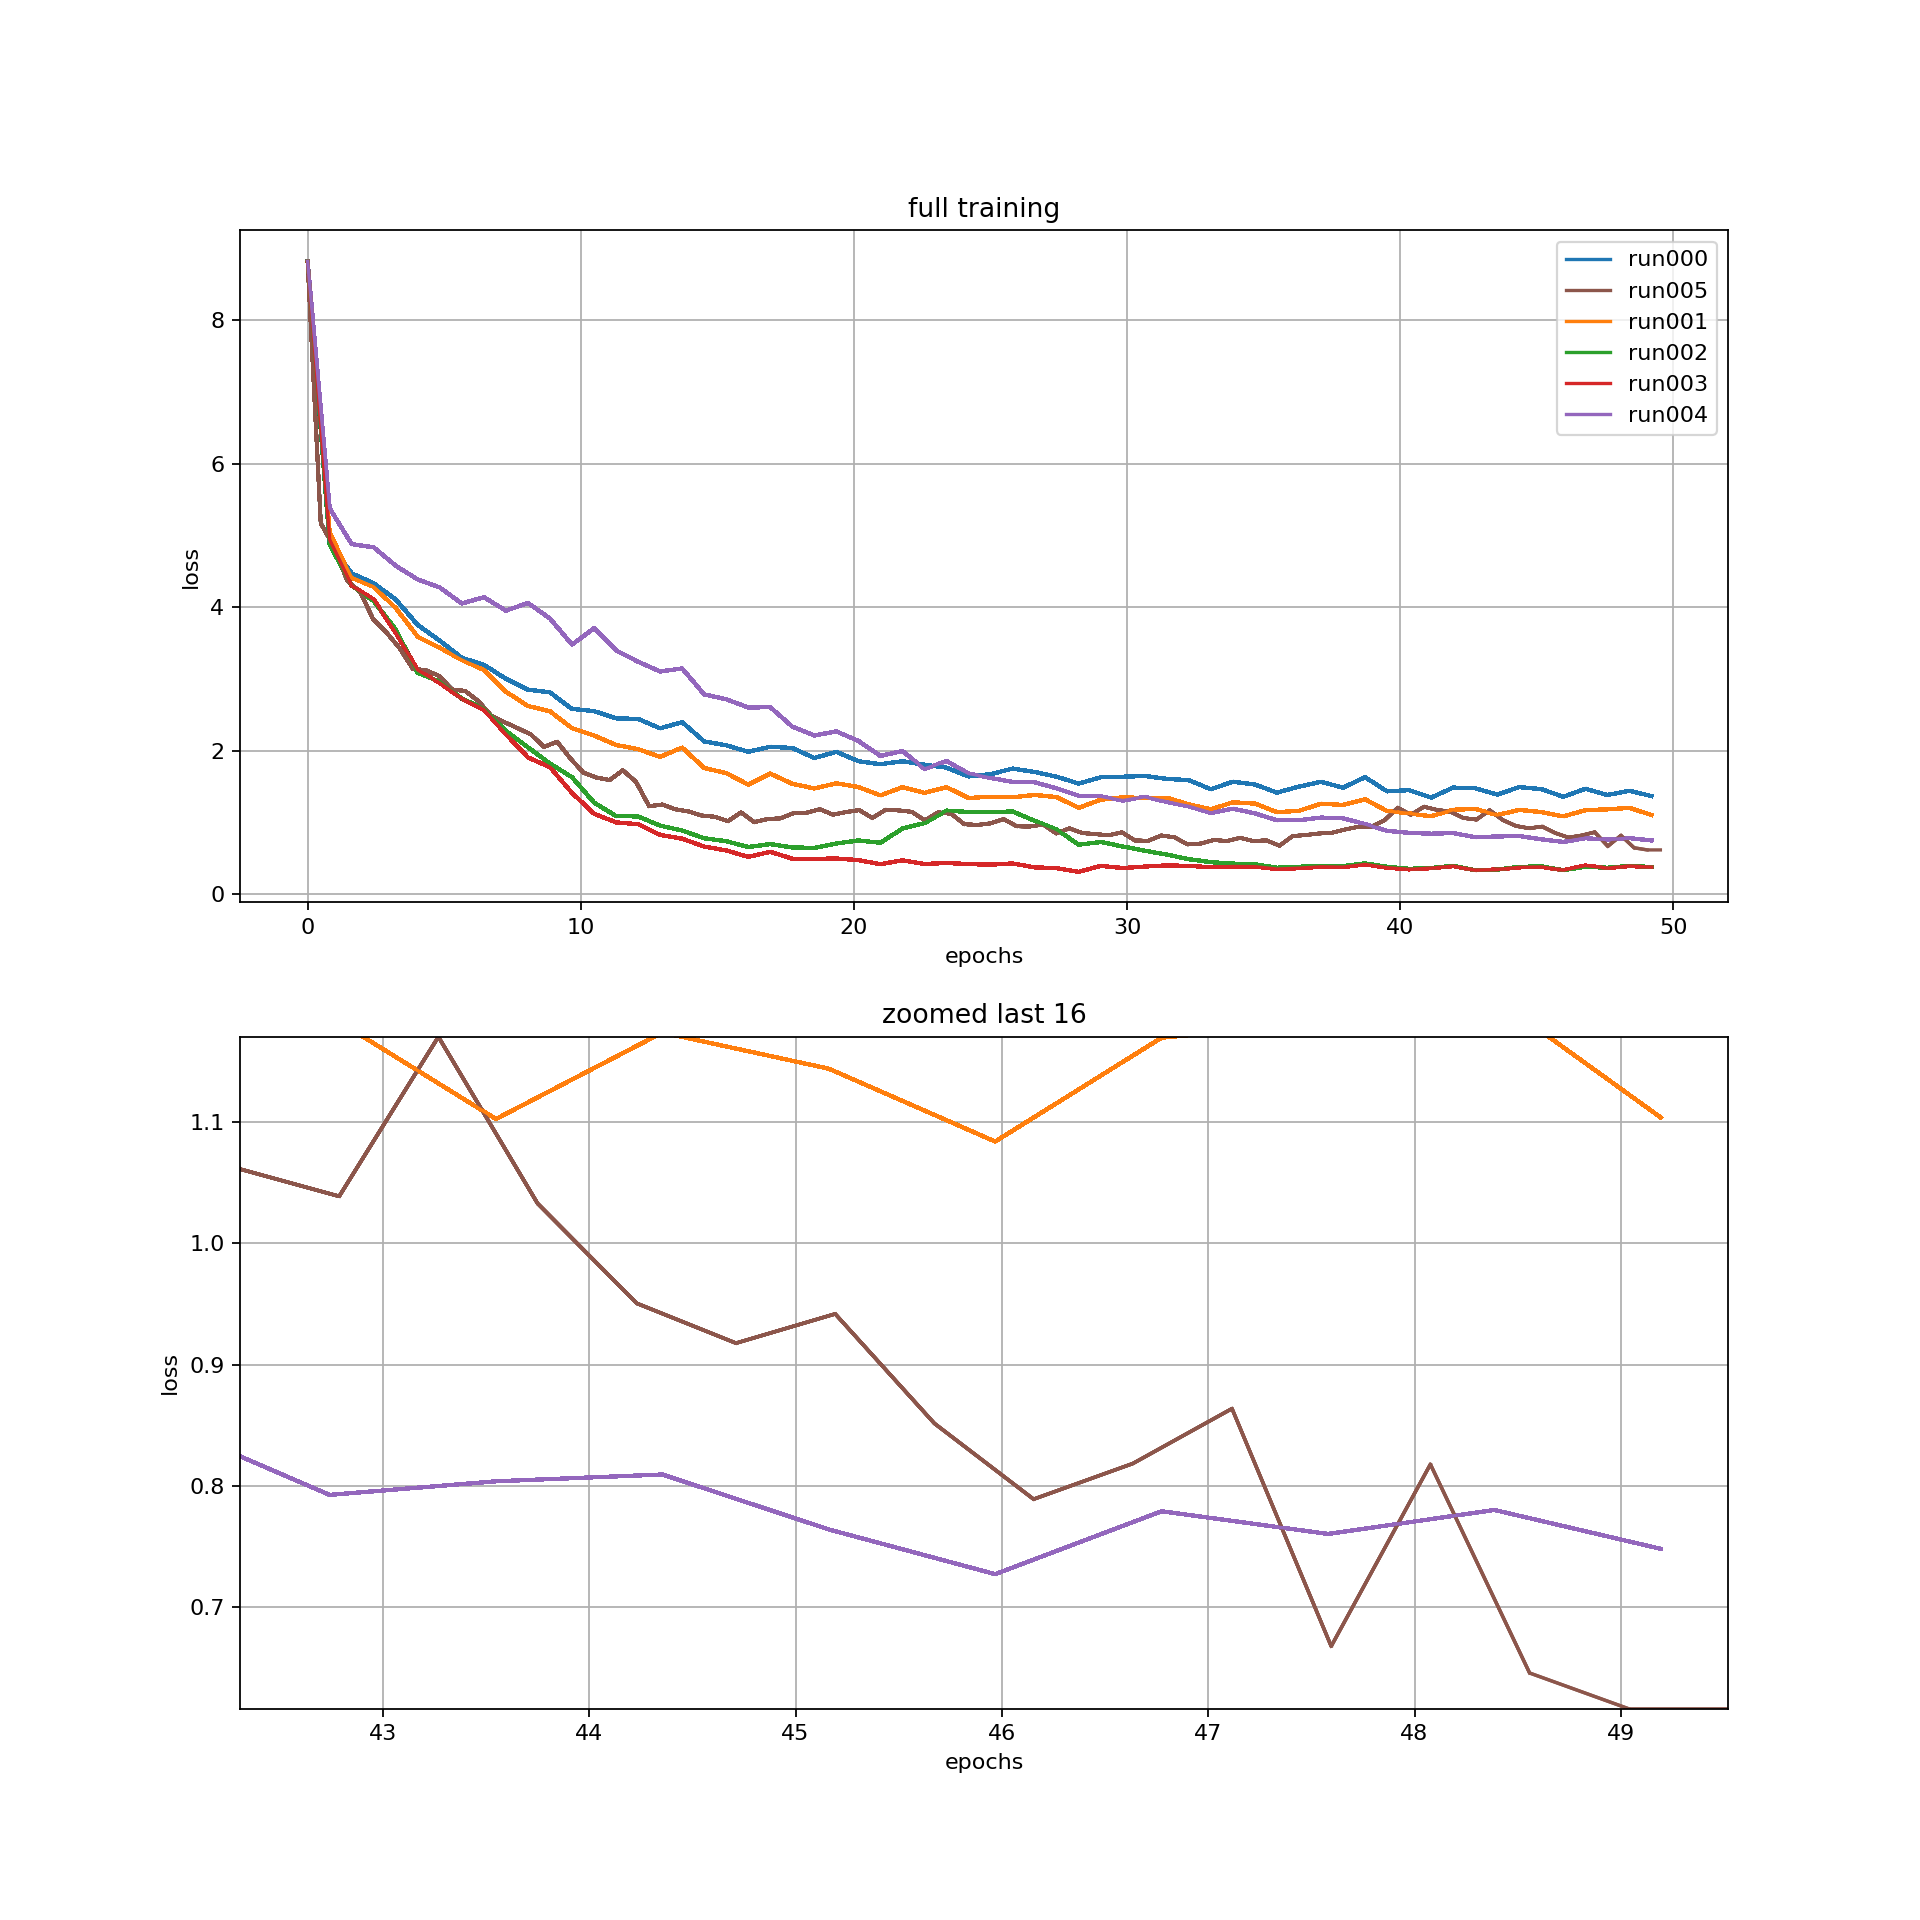

run000 avg_loss = 1.451570987701416
{'fc_init_weight_std': 0.1, 'rnn_size': 250, 'batch_size': 100, 'seq_length': 11, 'num_lstm_layers': 1, 'embedding_init_weight_std': 0.1, 'learning_rate': 0.02}

run001 avg_loss = 1.1699564456939697
{'fc_init_weight_std': 0.1, 'rnn_size': 500, 'batch_size': 100, 'seq_length': 11, 'num_lstm_layers': 1, 'embedding_init_weight_std': 0.1, 'learning_rate': 0.02}

run002 avg_loss = 0.3749431371688843
{'fc_init_weight_std': 0.1, 'rnn_size': 500, 'batch_size': 100, 'seq_length': 11, 'num_lstm_layers': 1, 'embedding_init_weight_std': 0.1, 'learning_rate': 0.01}

run003 avg_loss = 0.3703654408454895
{'fc_init_weight_std': 0.05, 'rnn_size': 500, 'batch_size': 100, 'seq_length': 11, 'num_lstm_layers': 1, 'embedding_init_weight_std': 0.1, 'learning_rate': 0.01}

run004 avg_loss = 0.8433812856674194
{'fc_init_weight_std': 0.1, 'rnn_size': 250, 'batch_size': 100, 'seq_length': 11, 'num_lstm_layers': 2, 'embedding_init_weight_std': 0.1, 'learning_rate': 0.01}

run00

In [53]:
import itertools
from itertools import product

num_epochs = 50
show_every_n_batches = 50

# range_dict = {
#     'batch_size': [80, 120],
#     'rnn_size': [200, 500],
#     'seq_length': [11,30],
#     'learning_rate': [0.01, 0.005],
#     'num_lstm_layers': [1, 2],
#     'fc_init_weight_std': [0.01, 0.1],
#     'embedding_init_weight_std': [0.01, 0.1]
# }

# param_list = [dict(zip(range_dict, x)) for x in itertools.product(*range_dict.values())]

param_list = [
    {'batch_size': 100, 'rnn_size': 250, 'seq_length': 11, 'learning_rate': 0.02, 
     'num_lstm_layers': 1, 'fc_init_weight_std': 0.1, 'embedding_init_weight_std': 0.1},
    {'batch_size': 100, 'rnn_size': 500, 'seq_length': 11, 'learning_rate': 0.02, 
     'num_lstm_layers': 1, 'fc_init_weight_std': 0.1, 'embedding_init_weight_std': 0.1},
    {'batch_size': 100, 'rnn_size': 500, 'seq_length': 11, 'learning_rate': 0.01, 
     'num_lstm_layers': 1, 'fc_init_weight_std': 0.1, 'embedding_init_weight_std': 0.1},
    {'batch_size': 100, 'rnn_size': 500, 'seq_length': 11, 'learning_rate': 0.01, 
     'num_lstm_layers': 1, 'fc_init_weight_std': 0.05, 'embedding_init_weight_std': 0.1},
    {'batch_size': 100, 'rnn_size': 250, 'seq_length': 11, 'learning_rate': 0.01, 
     'num_lstm_layers': 2, 'fc_init_weight_std': 0.1, 'embedding_init_weight_std': 0.1},
    {'batch_size': 60, 'rnn_size': 500, 'seq_length': 11, 'learning_rate': 0.01, 
     'num_lstm_layers': 1, 'fc_init_weight_std': 0.1, 'embedding_init_weight_std': 0.1},
]

plotter.init_plot()

for i, param_dict in enumerate(param_list):
    locals().update(param_dict)
    plotter.activate_params('run{:03}'.format(i), param_dict)
    build_and_train(plotter)

----

## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `num_epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `seq_length` to the length of sequence.
- Set `learning_rate` to the learning rate.
- Set `show_every_n_batches` to the number of batches the neural network should print progress.

In [61]:
# Number of Epochs
num_epochs = 30
# Batch Size
batch_size = 100
# RNN Size
rnn_size = 500
# Sequence Length
seq_length = 11
# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 200

num_lstm_layers = 1
fc_init_weight_std = 0.05
embedding_init_weight_std = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
save_dir = './save'

### Build the Graph
Build the graph using the neural network you implemented.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from tensorflow.contrib import seq2seq

train_graph = tf.Graph()
with train_graph.as_default():
    vocab_size = len(int_to_vocab)
    input_text, targets, lr = get_inputs()
    input_data_shape = tf.shape(input_text)
    cell, initial_state = get_init_cell(input_data_shape[0], rnn_size)
    logits, final_state = build_nn(cell, rnn_size, input_text, vocab_size)

    # Probabilities for generating words
    probs = tf.nn.softmax(logits, name='probs')

    # Loss function
    cost = seq2seq.sequence_loss(
        logits,
        targets,
        tf.ones([input_data_shape[0], input_data_shape[1]]))

    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    train_op = optimizer.apply_gradients(capped_gradients)

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
batches = get_batches(int_text, batch_size, seq_length)

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(num_epochs):
        state = sess.run(initial_state, {input_text: batches[0][0]})

        for batch_i, (x, y) in enumerate(batches):
            feed = {
                input_text: x,
                targets: y,
                initial_state: state,
                lr: learning_rate}
            train_loss, state, _ = sess.run([cost, final_state, train_op], feed)

            # Show every <show_every_n_batches> batches
            if (epoch_i * len(batches) + batch_i) % show_every_n_batches == 0:
                print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    epoch_i,
                    batch_i,
                    len(batches),
                    train_loss))


    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_dir)
    print('Model Trained and Saved')

Epoch   0 Batch    0/62   train_loss = 8.821
Epoch   3 Batch   14/62   train_loss = 3.685
Epoch   6 Batch   28/62   train_loss = 2.592
Epoch   9 Batch   42/62   train_loss = 1.612
Epoch  12 Batch   56/62   train_loss = 0.899
Epoch  16 Batch    8/62   train_loss = 0.615
Epoch  19 Batch   22/62   train_loss = 0.522
Epoch  22 Batch   36/62   train_loss = 0.431
Epoch  25 Batch   50/62   train_loss = 0.435
Epoch  29 Batch    2/62   train_loss = 0.400
Model Trained and Saved


# Train
Train the neural network on the preprocessed data.  If you have a hard time getting a good loss, check the [forms](https://discussions.udacity.com/) to see if anyone is having the same problem.

## Save Parameters
Save `seq_length` and `save_dir` for generating a new TV script.

In [64]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params((seq_length, save_dir))

# Checkpoint

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
seq_length, load_dir = helper.load_params()

## Implement Generate Functions
### Get Tensors
Get tensors from `loaded_graph` using the function [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name).  Get the tensors using the following names:
- "input:0"
- "initial_state:0"
- "final_state:0"
- "probs:0"

Return the tensors in the following tuple `(InputTensor, InitialStateTensor, FinalStateTensor, ProbsTensor)` 

In [66]:
def get_tensors(loaded_graph):
    """
    Get input, initial state, final state, and probabilities tensor from <loaded_graph>
    :param loaded_graph: TensorFlow graph loaded from file
    :return: Tuple (InputTensor, InitialStateTensor, FinalStateTensor, ProbsTensor)
    """
    names = ["input:0", "initial_state:0", "final_state:0", "probs:0"]
    return (loaded_graph.get_tensor_by_name(n) for n in names)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_get_tensors(get_tensors)

Tests Passed


### Choose Word
Implement the `pick_word()` function to select the next word using `probabilities`.

In [84]:
def pick_word(probabilities, int_to_vocab):
    """
    Pick the next word in the generated text
    :param probabilities: Probabilites of the next word
    :param int_to_vocab: Dictionary of word ids as the keys and words as the values
    :return: String of the predicted word
    """
    perturbed = probabilities + 0.01*np.random.randn(len(probabilities))
    return int_to_vocab[np.argmax(perturbed)]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_pick_word(pick_word)

Tests Passed


## Generate TV Script
This will generate the TV script for you.  Set `gen_length` to the length of TV script you want to generate.

In [85]:
gen_length = 200
# homer_simpson, moe_szyslak, or Barney_Gumble
prime_word = 'moe_szyslak'

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    input_text, initial_state, final_state, probs = get_tensors(loaded_graph)

    # Sentences generation setup
    gen_sentences = [prime_word + ':']
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})

    # Generate sentences
    for n in range(gen_length):
        # Dynamic Input
        dyn_input = [[vocab_to_int[word] for word in gen_sentences[-seq_length:]]]
        dyn_seq_length = len(dyn_input[0])

        # Get Prediction
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: dyn_input, initial_state: prev_state})
        
        pred_word = pick_word(probabilities[dyn_seq_length-1], int_to_vocab)

        gen_sentences.append(pred_word)
    
    # Remove tokens
    tv_script = ' '.join(gen_sentences)
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        tv_script = tv_script.replace(' ' + token.lower(), key)
    tv_script = tv_script.replace('\n ', '\n')
    tv_script = tv_script.replace('( ', '(')
        
    print(tv_script)

moe_szyslak:(covering nervous laughing) i got hooked on this stuff.
moe_szyslak: moe?!
moe_szyslak: no.
homer_simpson: not even a little one a good one. any of you.


homer_simpson:(gasps) what happened here?
moe_szyslak:(to homer) sir, has it is a secret!
homer_simpson:(gasps) gr-aargh!
moe_szyslak:(scared) look, all-all-all i got is much.(to moe) he seems nice.
lisa_simpson: how'd that nice to be you.
homer_simpson: oh, my. why is the good. you gotta do that.
moe_szyslak: you know, i just gotta warn you, marge.
moe_szyslak: all right, who rubbed my nickels?!
homer_simpson:(gasps) where'd you get that car.
moe_szyslak:(pleased) really? tell me something: i free beer.
moe_szyslak: eh, you know i love our family.
moe_szyslak: but i'd see the new now.
homer_simpson: you know, i feel pretty good. maybe i used to be the nigerian


# The TV Script is Nonsensical
It's ok if the TV script doesn't make any sense.  We trained on less than a megabyte of text.  In order to get good results, you'll have to use a smaller vocabulary or get more data.  Luckly there's more data!  As we mentioned in the begging of this project, this is a subset of [another dataset](https://www.kaggle.com/wcukierski/the-simpsons-by-the-data).  We didn't have you train on all the data, because that would take too long.  However, you are free to train your neural network on all the data.  After you complete the project, of course.
# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.